In [1]:
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist=input_data.read_data_sets("/tmp/data/",one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
#Generator implementation
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1=tf.layers.dense(inputs=z,units=128)
        #leaky activation function
        alpha=0.01
        hidden1=tf.maximum(alpha*hidden1,hidden1)
        
        hidden2=tf.layers.dense(inputs=hidden1,units=128)
        hidden2=tf.maximum(alpha*hidden2,hidden2)
        
        output=tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        
        return output
        
        

In [5]:
#Discriminatorimplementation
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1=tf.layers.dense(inputs=X,units=128)
        #leaky activation function
        alpha=0.01
        hidden1=tf.maximum(alpha*hidden1,hidden1)
        
        hidden2=tf.layers.dense(inputs=hidden1,units=128)
        hidden2=tf.maximum(alpha*hidden2,hidden2)
        
        #we just ned to know if it is true or false
        logits=tf.layers.dense(hidden2,units=1)
        output=tf.sigmoid(logits)
        
        return output,logits

In [6]:
#placeholder for noise and input.
real_images=tf.placeholder(tf.float32,shape=[None,784])
z=tf.placeholder(tf.float32,shape=[None,100])


In [7]:
G=generator(z)

In [8]:
D_output_real,D_logits_real=discriminator(real_images)

In [9]:
D_output_fake,D_logits_fake=discriminator(G,reuse=True)

In [10]:
#Loss function
def loss_function(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))


In [11]:
D_real_loss=loss_function(D_logits_real,tf.ones_like(D_logits_real)*0.9)
D_fake_loss=loss_function(D_logits_fake,tf.zeros_like(D_logits_fake))


In [12]:
G_loss=loss_function(D_logits_fake,tf.ones_like(D_logits_fake))

In [13]:
D_loss=D_real_loss+D_fake_loss

In [14]:
#Optimizer
learning_rate=0.001
tvars=tf.trainable_variables()
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]

In [15]:
D_traier=tf.train.AdamOptimizer(learning_rate).minimize(D_loss,var_list=d_vars)

In [16]:
G_traier=tf.train.AdamOptimizer(learning_rate).minimize(G_loss,var_list=g_vars)

In [17]:
#trainig session
batch_size=100
epochs=30
init=tf.global_variables_initializer()

In [18]:
samples=[]
from datetime import datetime
now=datetime.utcnow().strftime("%Y%m%d%H%M%S")
#saver=tf.train.Saver()
root_logdir="tf_logs"
logdir="{}/run{}/".format(root_logdir,now)
train_set = (mnist.train.images - 0.5) / 0.5
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()

training start!


In [19]:
with tf.Session() as sess:
    writer=tf.summary.FileWriter(logdir,tf.get_default_graph())
    sess.run(init)
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for epoch in range(epochs):
        num_batches=mnist.train.num_examples//batch_size
        
        for i in range(num_batches):
            batch_im=train_set[i*batch_size:(i+1)*batch_size]
            #batch_im=batch[0].reshape((batch_size,784))
            #batch_im=batch_im*2-1
            
            batch_z=np.random.uniform(-1,1,size=(batch_size,100))
            
            loss_d_, _=sess.run([D_loss,D_traier],feed_dict={real_images:batch_im,z:batch_z})
            D_losses.append(loss_d_)
            loss_g_,_=sess.run([G_loss,G_traier],feed_dict={z:batch_z})
            G_losses.append(loss_g_)
            
        
        
        sample_z=np.random.uniform(-1,1,size=(1,100))
        gen_sample=sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        samples.append(gen_sample)
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1),epochs, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    writer.close()

[1/30] - ptime: 8.04 loss_d: 0.459, loss_g: 3.701
[2/30] - ptime: 16.02 loss_d: 0.463, loss_g: 3.886
[3/30] - ptime: 24.12 loss_d: 0.515, loss_g: 3.882
[4/30] - ptime: 32.10 loss_d: 0.622, loss_g: 4.048
[5/30] - ptime: 40.08 loss_d: 0.705, loss_g: 4.399
[6/30] - ptime: 48.08 loss_d: 0.738, loss_g: 4.075
[7/30] - ptime: 56.08 loss_d: 0.776, loss_g: 3.956
[8/30] - ptime: 64.09 loss_d: 0.839, loss_g: 4.024
[9/30] - ptime: 72.38 loss_d: 0.864, loss_g: 3.865
[10/30] - ptime: 80.83 loss_d: 0.877, loss_g: 3.711
[11/30] - ptime: 89.14 loss_d: 0.869, loss_g: 3.640
[12/30] - ptime: 97.30 loss_d: 0.863, loss_g: 3.571
[13/30] - ptime: 105.33 loss_d: 0.856, loss_g: 3.521
[14/30] - ptime: 113.33 loss_d: 0.850, loss_g: 3.489
[15/30] - ptime: 121.33 loss_d: 0.846, loss_g: 3.480
[16/30] - ptime: 129.33 loss_d: 0.839, loss_g: 3.448
[17/30] - ptime: 138.26 loss_d: 0.832, loss_g: 3.410
[18/30] - ptime: 146.83 loss_d: 0.827, loss_g: 3.406
[19/30] - ptime: 154.82 loss_d: 0.822, loss_g: 3.377
[20/30] - ptime

In [20]:
root = 'MNIST_DCGAN_results/'
if not os.path.isdir(root):
    os.mkdir(root)
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.save(outfile, samples)
outfile.seek(0)
sam=np.load(outfile)[19,:,:]

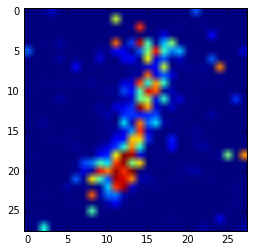

In [21]:
plt.imshow(sam.reshape(28,28))

In [22]:
saver=tf.train.Saver(var_list=g_vars)

In [23]:
#with tf.Session() as sess:
 #   saver.restore(sess,'')
    #generate sample